# Read the data and rename some parameters
Ref: He et al., 2011, SIMULATING TRANSIENT CLIMATE EVOLUTION OF THE LAST DEGLACIATION WITH CCSM3

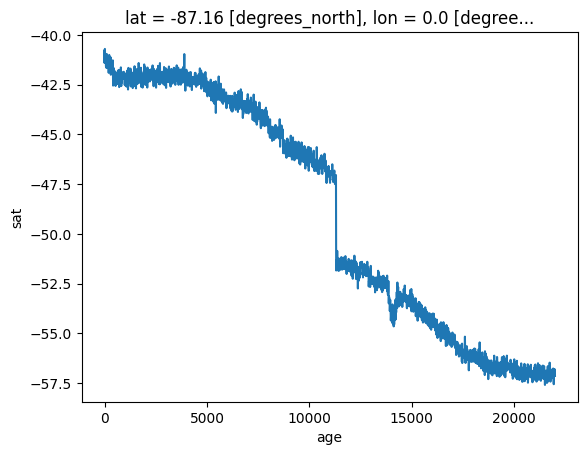

In [1]:
import xarray as xr

# import .nc data
ds = xr.open_dataset('TraCE_data/trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')

# rename the TREFHT to sat
ds = ds.rename({'TREFHT': 'sat'})
# rename the time to age
ds = ds.rename({'time': 'age'})
# multiply age by 1000
ds['age'] = ds['age'] * -1000

# convert the sat to degrees C
ds['sat'] = ds['sat'] - 273.15

ds = ds[['sat']]
# plot a record from the ds_sat at given lat and lon
ds['sat'].isel(lat=0, lon=0).plot()

# The age of LGMR data starts from 100 and ends at 23900 with step of 200 yr. The age of TraCE starts from -29 and ends at 22000, so we resample the TraCE data to match the resolution of LGMR

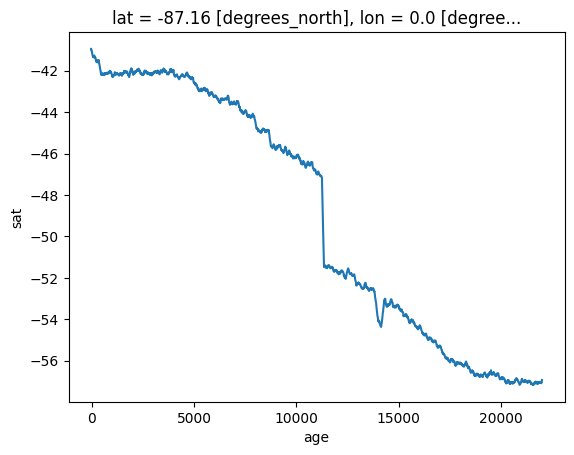

In [108]:
import numpy as np
import xarray as xr

# smoothed_sat = ds['sat'].rolling(age=10, center=True).mean()
smoothed_sat = ds['sat'].rolling(age=10, center=True, min_periods=1).mean()
ds_sat = smoothed_sat.to_dataset(name='sat')
ds_sat['sat'].isel(lat=0, lon=0).plot()

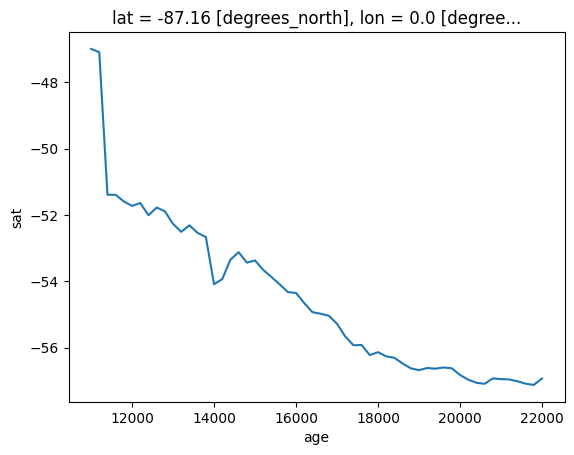

In [2]:
import numpy as np
import xarray as xr

# smoothed_sat = ds['sat'].rolling(age=10, center=True).mean()
smoothed_sat = ds['sat'].rolling(age=10, center=True, min_periods=1).mean()


# Ensure new_age is within the bounds of the original 'age' data
new_age = np.arange(11000, 22001, 200)

# Interpolate the smoothed 'sat' data variable to the new 'age' coordinate
resampled_sat = smoothed_sat.interp(age=new_age)
# resampled_sat=ds['sat'].interp(age=new_age, method='linear')


# Create a new xarray Dataset with the resampled 'sat' data variable
ds_sat = resampled_sat.to_dataset(name='sat')

# ds_sat
# plot a record from the ds_sat at given lat and lon
ds_sat['sat'].isel(lat=0, lon=0).plot()

# Alternative, don't resample data, just crop the data for age>11

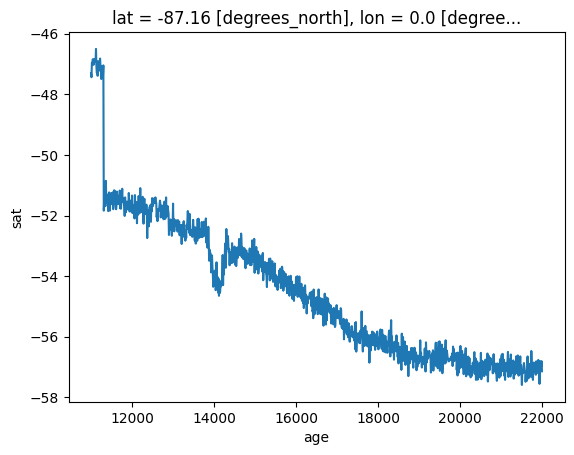

In [120]:
ds_sat=ds
ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)
ds_sat['sat'].isel(lat=0, lon=0).plot()

# PCA

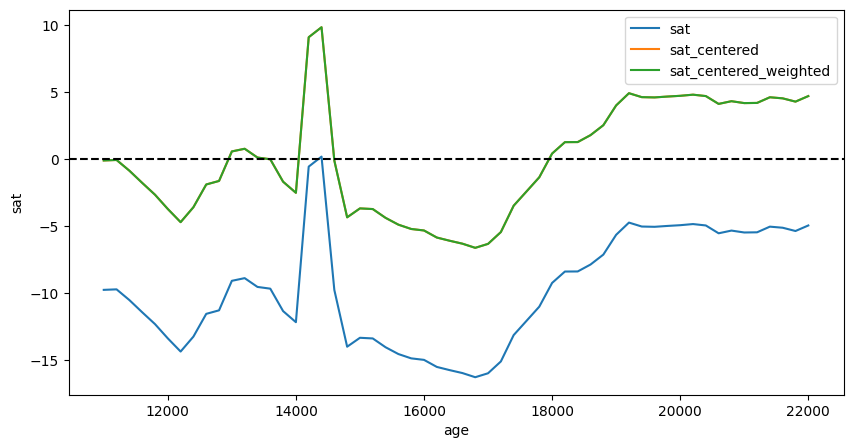

In [10]:
from toolbox import PCA_functions as pf
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
# ds_sat = pf.apply_weighting(ds_sat)


# Calculate the weight
weight = np.cos(np.deg2rad(ds['lat']))
weight = xr.where(weight < 0, 0, weight)
ds_sat['weight'] = weight
ds_sat['sat_centered_weighted'] =ds_sat['sat_centered']

# 3. Plot the Centered and Weighted Data
# Assuming you want to plot data for lat=0 and lon=0
lat_index = 40
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)


In [4]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_variance, eofs, pcs = pf.sat_PCA(ds_sat)
print('Explained variance:', exp_variance)


shape of the reshaped sat_centered_weighted: (4608, 56)
shape of u, s, vh: (4608, 4608) (56,) (56, 56)
shape of EOFs: (4608, 2)
shape of PCs: (56, 2)
Explained variance: [8.46519807e-01 1.15073804e-01 2.06460114e-02 6.27034357e-03
 3.56739805e-03 2.12003628e-03 1.56586240e-03 9.64302497e-04
 7.74819299e-04 4.47479742e-04 3.23328801e-04 2.65518406e-04
 2.21341487e-04 1.62385706e-04 1.22323827e-04 1.05589440e-04
 8.10537783e-05 6.86654059e-05 6.11127153e-05 5.78746131e-05
 5.19417443e-05 4.25597966e-05 3.81143464e-05 3.51991412e-05
 3.35459762e-05 3.01051886e-05 2.91882128e-05 2.65507183e-05
 2.46326952e-05 2.28317067e-05 1.99269445e-05 1.90350484e-05
 1.64121604e-05 1.47068516e-05 1.35031813e-05 1.34377270e-05
 1.25550655e-05 1.20527465e-05 1.10160391e-05 1.03229548e-05
 9.92760067e-06 9.81361753e-06 8.86810996e-06 8.59274701e-06
 8.27703111e-06 7.93712297e-06 6.91705942e-06 6.60798952e-06
 6.15324656e-06 5.68769358e-06 5.56651797e-06 5.11427124e-06
 4.97212710e-06 4.59752808e-06 4.2701

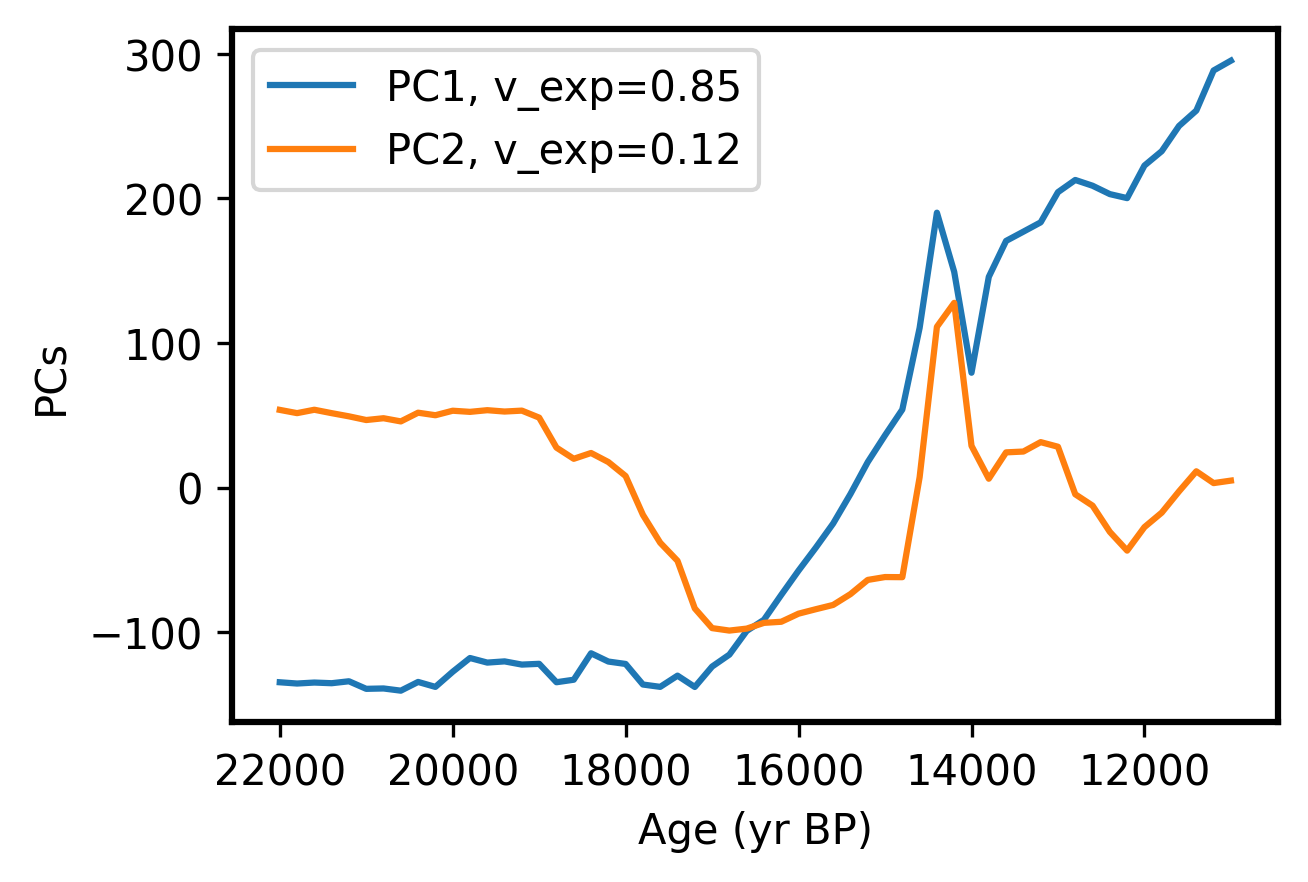

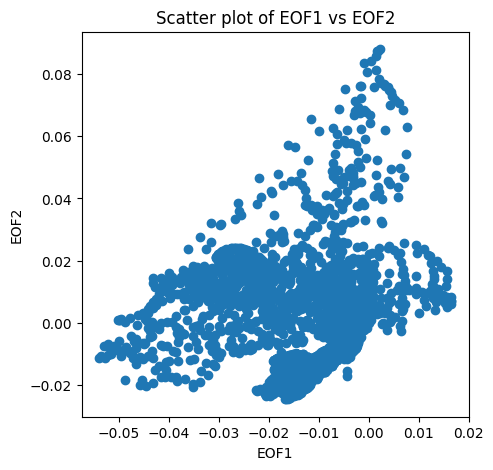

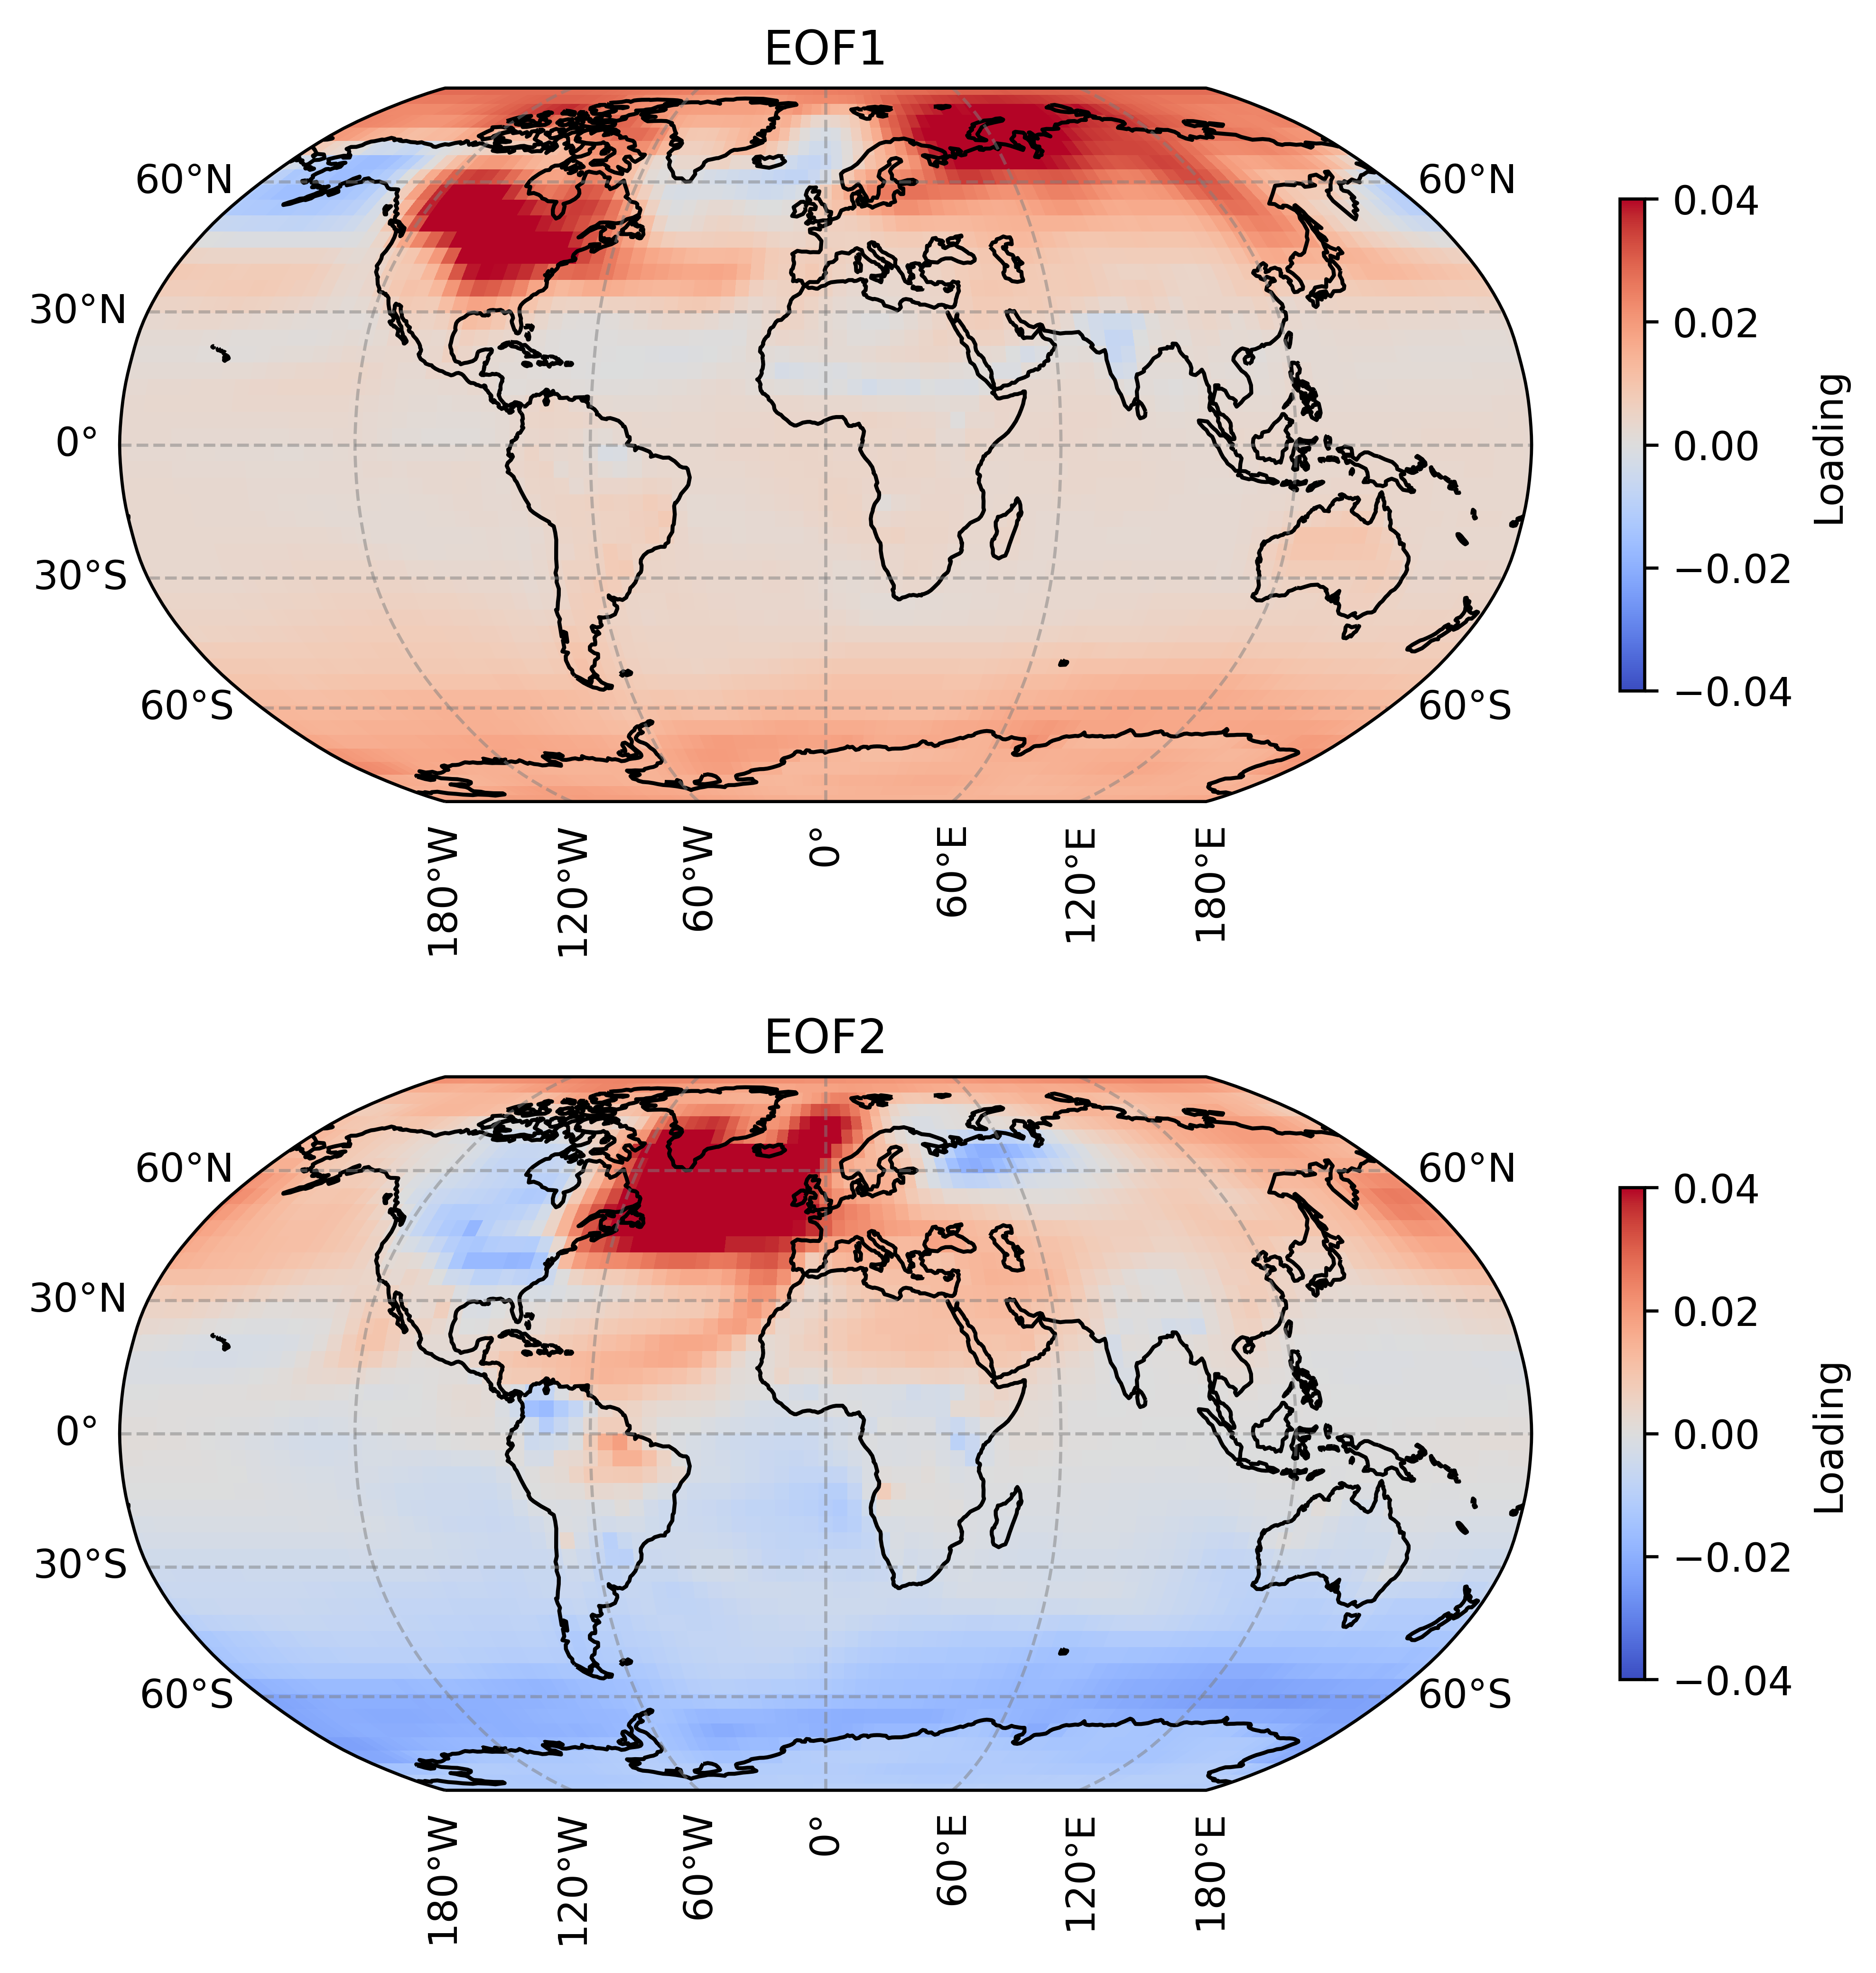

(<Figure size 4800x5400 with 4 Axes>,
 array([<GeoAxesSubplot: title={'center': 'EOF1'}>,
        <GeoAxesSubplot: title={'center': 'EOF2'}>], dtype=object))

In [5]:
# 5. Plot PCs
pf.plot_pcs(ds_sat['age'].values, pcs, exp_variance)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs, ds_sat['lat'].values, ds_sat['lon'].values)

# GMM

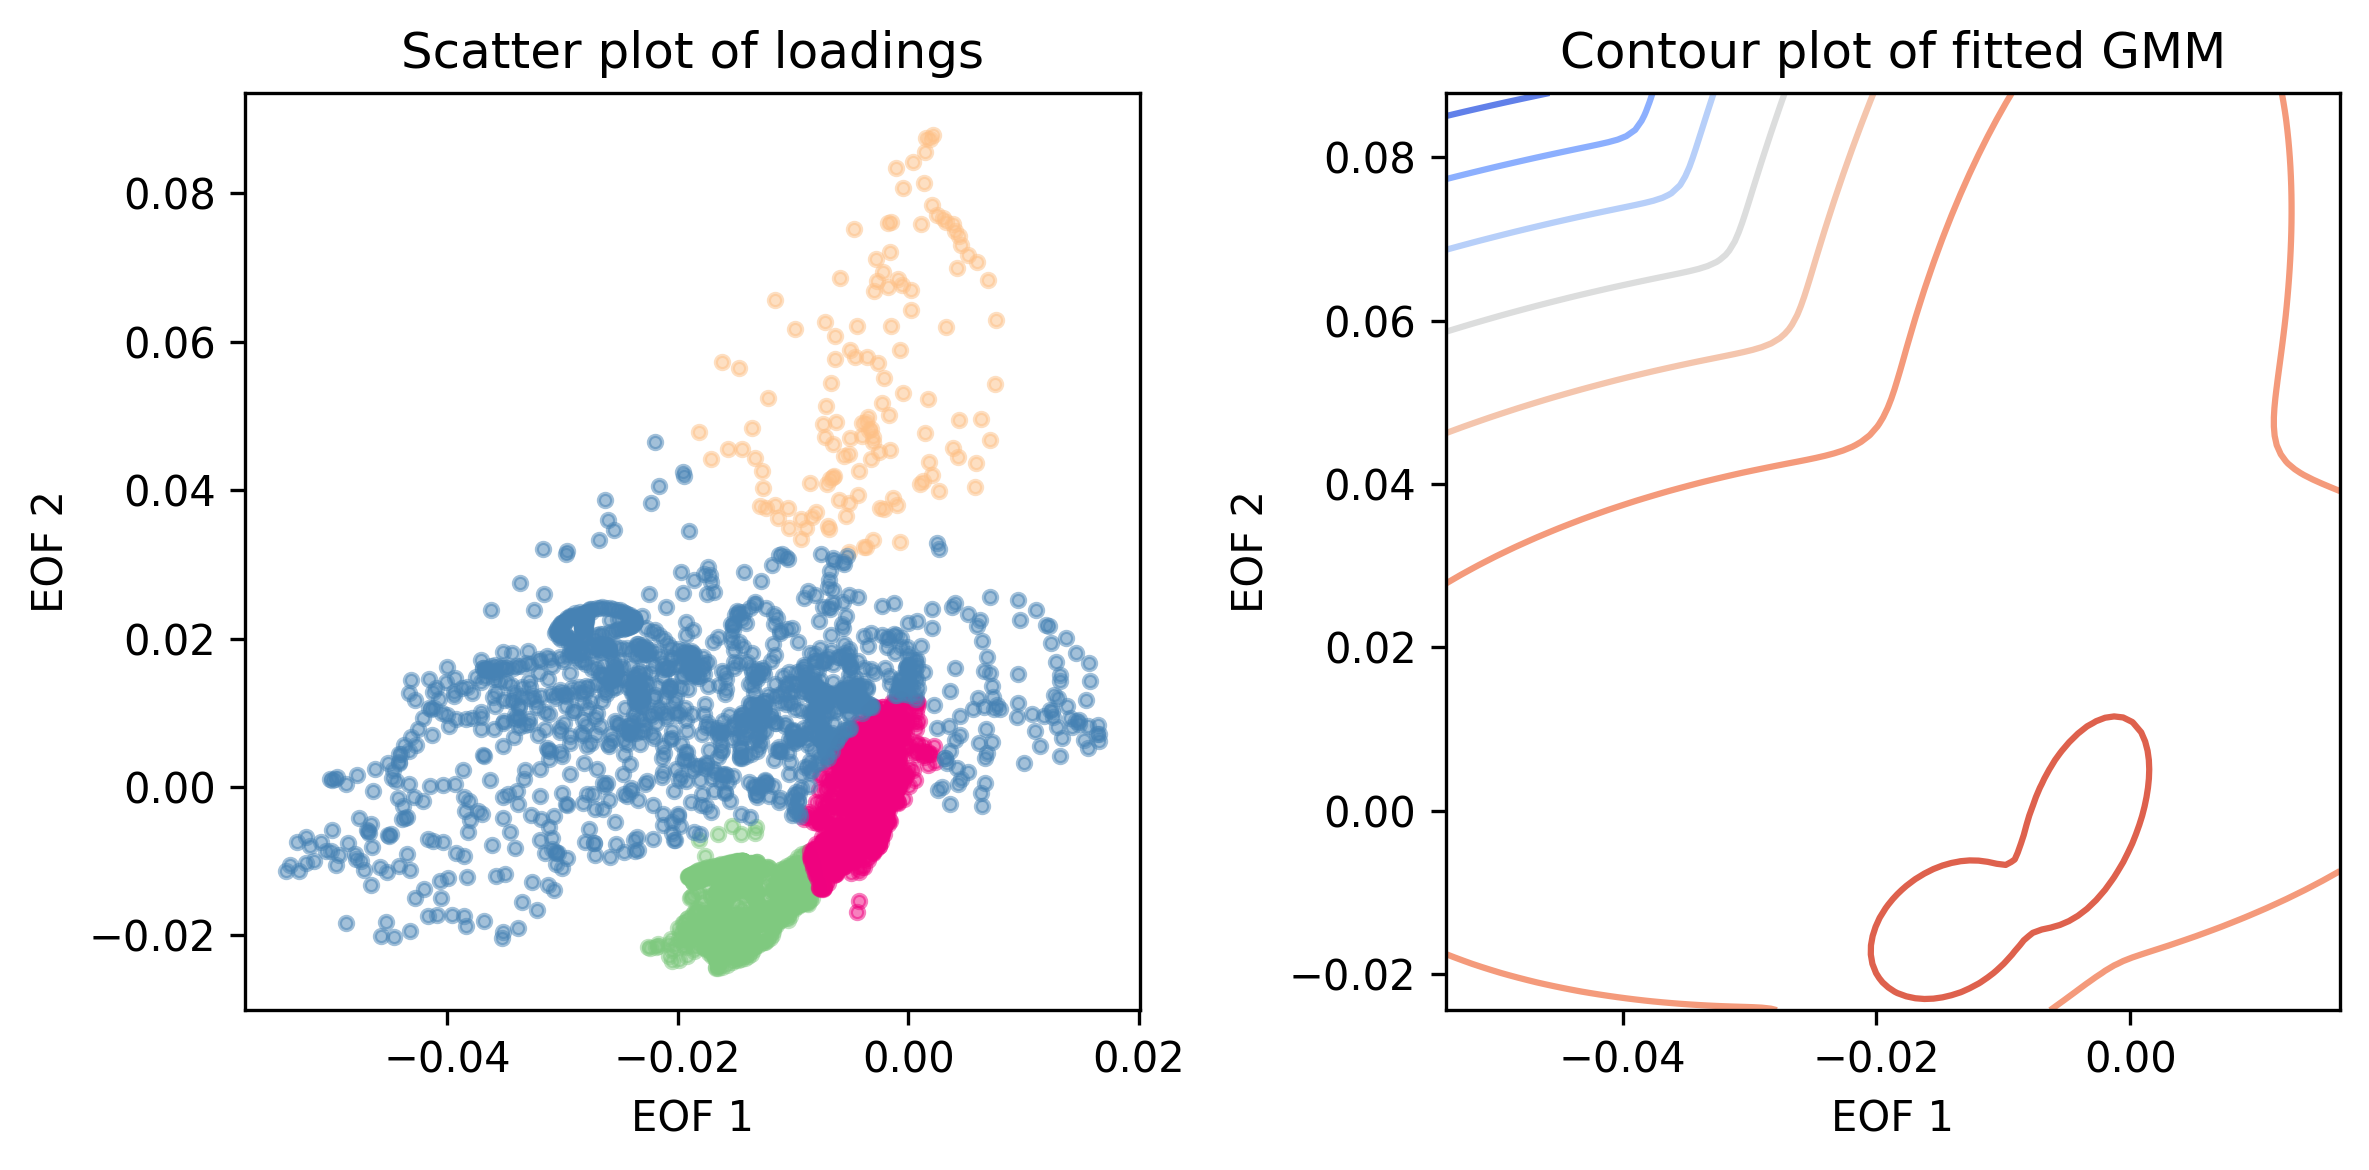

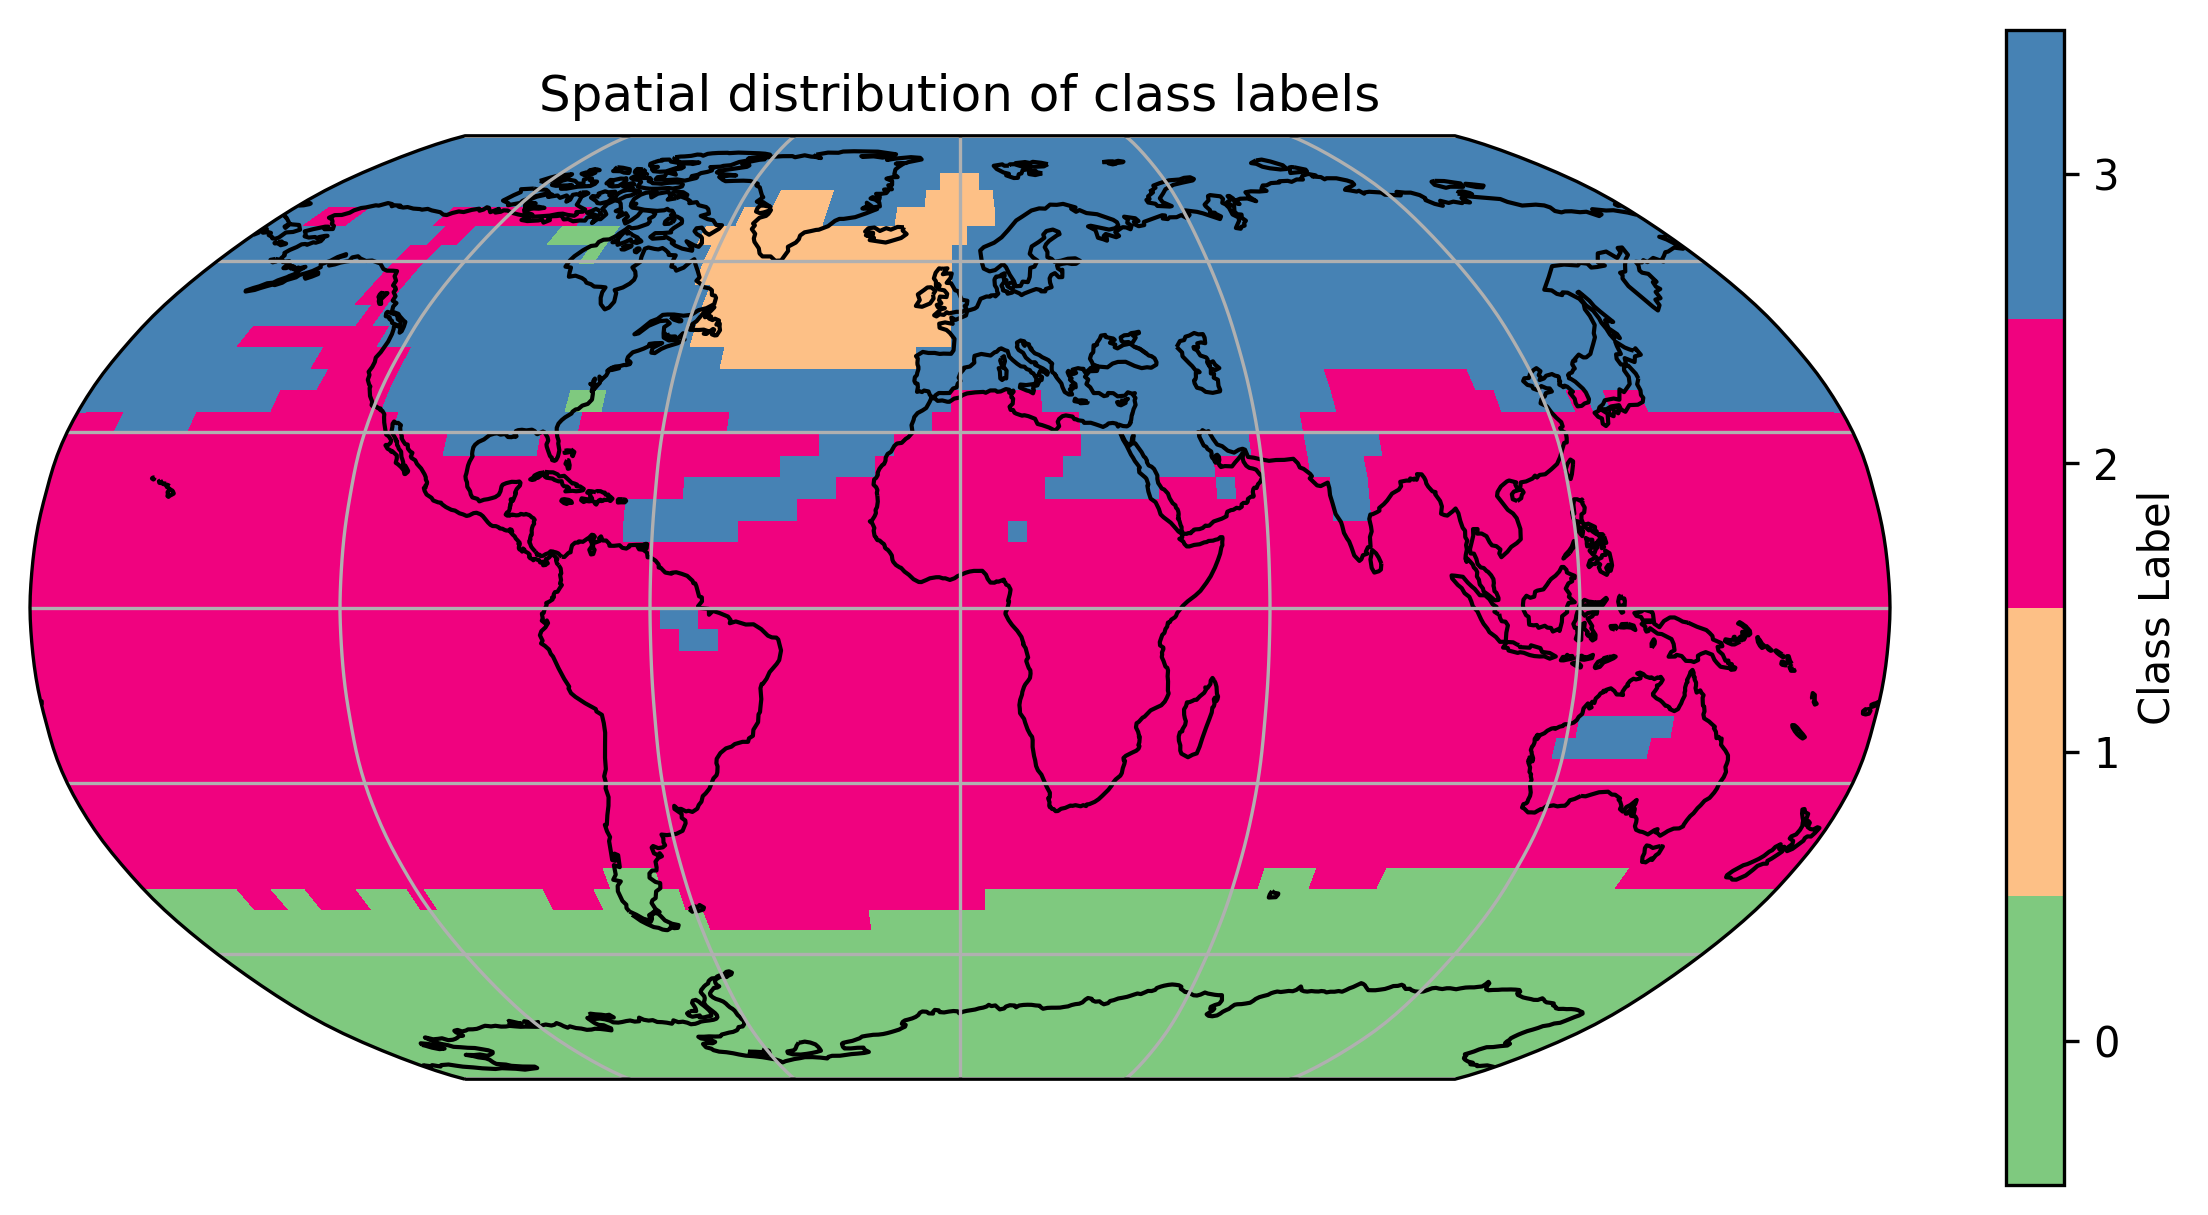

In [12]:
from toolbox import GMM_functions as gf
ds_EOFs_GMM,reshaped_probs=gf.GMM4EOFS(eofs, ds_sat,n_components=4)
gf.plot_labels(ds_EOFs_GMM)

In [13]:
from toolbox import GMM_functions as gf
import importlib
importlib.reload(gf)

uncor_weighted_avg=gf.plot_weighted_average_curve(ds_EOFs_GMM.copy(), dpi=900)